In [432]:

import os
import joblib
import librosa
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from statistics import mode
import seaborn as sns 
from scipy.io import wavfile as wav
from imblearn.over_sampling import SMOTE
from IPython.display import Image
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,  recall_score
%matplotlib inline

<h1>EDA</h1>

In [194]:
healthy_dir = "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/AudioDataset/HC_AH"
parkinsons_dir = "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/AudioDataset/PD_AH"

Librosa convert stero audio to mono audio and also normalizes the waveform

In [195]:
def plot_waveform(audio_file, title):
    data, sample_rate = librosa.load(audio_file)
    plt.figure(figsize=(14, 5))
    plt.plot(data)
    plt.title(title + " Waveform")
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

In [196]:
healthy_files = os.listdir(healthy_dir)
for file in healthy_files:
    audio_file = os.path.join(healthy_dir, file)
    plot_waveform(audio_file, "Healthy")
   
    

In [197]:
parkinsons_files = os.listdir(parkinsons_dir)
for file in parkinsons_files:
    audio_file = os.path.join(parkinsons_dir, file)
    plot_waveform(audio_file, "Parkinson's")


Feature Extraction

In [198]:
def extract_features(file_path, target_sr=22050):
    audio, sr = librosa.load(file_path, sr=target_sr)  
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

In [199]:
parkinsons_files = os.listdir(parkinsons_dir)
dataset=[]
for file in parkinsons_files:
    audio_file = os.path.join(parkinsons_dir, file)
    data = extract_features(audio_file)
    dataset.append([data,0])

In [200]:
df = pd.DataFrame(dataset, columns=['mfcc','label'])

In [253]:
def extract_features(file_path,target_sr=22050,n_fft=512):
    audio, sr = librosa.load(file_path, sr=target_sr)  

    features = []
    fo = np.min(audio)
    fhi = np.max(audio)
    flo = np.min(np.abs(np.fft.fft(audio)))
    features.extend([fo, fhi, flo])
    
    jitter = librosa.effects.harmonic(audio)
    jitter_perc = np.mean(librosa.feature.rms(y=jitter))
    jitter_abs = np.mean(librosa.feature.rms(y=jitter, frame_length=1, hop_length=1))
    rap = np.mean(librosa.onset.onset_strength(y=audio, sr=sr, hop_length=512))
    ddp = rap * 2
    ppq = np.mean(librosa.feature.tempogram(y=audio, sr=sr))
    features.extend([jitter_perc, jitter_abs, rap, ppq, ddp])
    
    shimmer = np.mean(np.abs(np.diff(audio))) / np.mean(np.abs(audio))
    shimmer_db = 10 * np.log10(shimmer)
    apq3 = np.mean(librosa.feature.spectral_bandwidth(S=np.abs(librosa.stft(audio)), sr=sr, p=3))
    apq5 = np.mean(librosa.feature.spectral_bandwidth(S=np.abs(librosa.stft(audio)), sr=sr, p=5))
    apq = np.mean(librosa.feature.spectral_flatness(y=audio))
    dda = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    features.extend([shimmer, shimmer_db, apq3, apq5, apq, dda])
    
    nhr = np.mean(librosa.feature.zero_crossing_rate(audio)**2)
    hnr = np.mean(librosa.effects.harmonic(audio) / librosa.effects.percussive(audio))
    rpde = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr, fmin=50.0))
    dfa = np.mean(librosa.feature.tonnetz(y=audio, sr=sr))
    features.extend([nhr, hnr, rpde, dfa])
    
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    spread1 = np.mean(centroid)
    spread2 = np.mean(bandwidth)
    d2 = spread1 / spread2
    ppe = np.mean(librosa.feature.mfcc(y=audio, sr=sr))
    features.extend([spread1, spread2, d2,ppe])
   
    
    return features

In [254]:
def create_augmented_dataset(data_folder, label):
    dataset = []
    for file_name in os.listdir(data_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(data_folder, file_name)
            features = extract_features(file_path)  # Extract features using the provided function
            dataset.append(features + [label])

            # Aggressive data augmentation
            y, sr = librosa.load(file_path, duration=3)
            for i in range(5):
                pitch_shifted_features = extract_features(file_path)  # Extract features from the pitch-shifted audio
                dataset.append(pitch_shifted_features + [label])
    
    return dataset

In [ ]:
augmented_healthy_data = create_augmented_dataset(healthy_dir , 0)
augmented_parkinsons_data = create_augmented_dataset(parkinsons_dir , 1)

In [256]:
combined_data = augmented_healthy_data + augmented_parkinsons_data
num_features = 7  # Number of features returned by extract_features function
df_columns = ['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP','MDVP:Shimmer', 'MDVP:Shimmer_dB', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE'] + ['Label']
df = pd.DataFrame(combined_data, columns=df_columns)

In [258]:
output_file_path = "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/AudioDataset/Audio.csv"
df.to_csv(output_file_path, index=False)

In [259]:
df.head()

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer_dB,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,Label
0,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764253,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0
1,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764253,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0
2,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764253,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0
3,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764253,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0
4,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764253,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo           474 non-null    float32
 1   MDVP:Fhi          474 non-null    float32
 2   MDVP:Flo          474 non-null    float64
 3   MDVP:Jitter(%)    474 non-null    float32
 4   MDVP:Jitter(Abs)  474 non-null    float32
 5   MDVP:RAP          474 non-null    float32
 6   MDVP:PPQ          474 non-null    float64
 7   Jitter:DDP        474 non-null    float64
 8   MDVP:Shimmer      474 non-null    float32
 9   MDVP:Shimmer_dB   474 non-null    float64
 10  Shimmer:APQ3      474 non-null    float64
 11  Shimmer:APQ5      474 non-null    float64
 12  MDVP:APQ          474 non-null    float32
 13  Shimmer:DDA       474 non-null    float64
 14  NHR               474 non-null    float64
 15  HNR               474 non-null    float32
 16  RPDE              474 non-null    float64
 1

In [262]:
parkinsons = df.sample(frac=1, random_state=42).copy()

In [266]:
X = parkinsons.drop(["Label"], axis=1) 
y = parkinsons["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

In [270]:
parkinsons = X_train.copy()
parkinsons

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer_dB,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
103,-1.001618,1.071820,0.035595,0.306474,0.246596,0.791794,0.169297,1.583589,0.140789,-8.514316,...,9.765732e-07,1209.699691,0.002302,-11.585214,23.805462,0.000454,766.543530,659.612689,1.162112,-8.559034
407,-1.009482,0.961631,0.006632,0.247555,0.199374,0.839373,0.199031,1.678745,0.170675,-7.678295,...,2.355665e-07,1335.735739,0.002912,-5.589581,23.624297,-0.081223,872.361698,766.868660,1.137563,-2.502594
264,-1.676252,1.620146,0.006154,0.360026,0.316983,1.137859,0.150074,2.275718,0.178096,-7.493464,...,7.469728e-07,1605.995352,0.006247,-12.672595,22.908855,-0.007482,1050.618544,724.664062,1.449801,-7.182133
313,-1.052253,0.987321,0.002371,0.182343,0.137047,0.854493,0.105129,1.708986,0.272794,-5.641648,...,1.095481e-06,1364.705757,0.007141,57.265629,24.320797,-0.065863,1023.286648,618.603936,1.654187,-13.120746
274,-0.842686,1.141831,0.000413,0.309369,0.247355,0.760994,0.087936,1.521988,0.446342,-3.503320,...,2.157189e-06,2002.424760,0.022484,6.545356,25.847848,0.144562,1511.409905,714.526047,2.115262,-11.180936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,-0.648297,1.099883,0.011938,0.180205,0.114682,0.682648,0.218315,1.365295,0.294419,-5.310348,...,6.520812e-06,1556.888811,0.008732,-11.902169,25.707668,-0.060110,1056.982404,646.055932,1.636054,-6.436989
139,-1.102848,1.179701,0.000106,0.180312,0.113340,0.733050,0.180751,1.466100,0.287180,-5.418454,...,1.284670e-07,2944.039562,0.008637,10.572964,26.573422,-0.008992,1307.306850,1079.885816,1.210597,-9.292967
359,-1.125867,1.003664,0.045103,0.122202,0.085945,0.721475,0.105050,1.442950,0.260503,-5.841873,...,3.356231e-05,1902.752131,0.005877,-65.924767,26.316206,0.001489,1090.028171,793.080028,1.374424,-12.362763
231,-1.021209,0.821491,0.023709,0.224759,0.155852,0.536916,0.193057,1.073833,0.206748,-6.845578,...,1.452787e-05,1439.598822,0.003378,-428.358093,25.197522,-0.016524,942.771002,742.252732,1.270148,-7.253228


In [271]:
parkinsons.iloc[0]

MDVP:Fo            -1.001618e+00
MDVP:Fhi            1.071820e+00
MDVP:Flo            3.559491e-02
MDVP:Jitter(%)      3.064736e-01
MDVP:Jitter(Abs)    2.465962e-01
MDVP:RAP            7.917944e-01
MDVP:PPQ            1.692972e-01
Jitter:DDP          1.583589e+00
MDVP:Shimmer        1.407889e-01
MDVP:Shimmer_dB    -8.514316e+00
Shimmer:APQ3        9.087476e+02
Shimmer:APQ5        1.339300e+03
MDVP:APQ            9.765732e-07
Shimmer:DDA         1.209700e+03
NHR                 2.301616e-03
HNR                -1.158521e+01
RPDE                2.380546e+01
DFA                 4.539511e-04
spread1             7.665435e+02
spread2             6.596127e+02
D2                  1.162112e+00
PPE                -8.559034e+00
Name: 103, dtype: float64

In [272]:
# Extracting features
features = [feature for feature in parkinsons.columns]

In [273]:
parkinsons.isna().sum()

MDVP:Fo             0
MDVP:Fhi            0
MDVP:Flo            0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer_dB     0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [275]:
# initialize and scale values
scaler = StandardScaler()
scaler.fit(parkinsons[features])
parkinsons[features] = scaler.transform(parkinsons[features])

In [279]:
joblib.dump(scaler, "Audio_scaler_joblib")

['scaler_joblib']

In [280]:
y_train.value_counts(normalize=True)

Label
1    0.501319
0    0.498681
Name: proportion, dtype: float64

In [281]:
parkinsons = pd.concat([parkinsons, y_train], axis=1)

In [286]:
smote = SMOTE(random_state=51)
X = parkinsons.drop("Label", axis=1) 
y = parkinsons["Label"]
X_train, y_train = smote.fit_resample(X, y)

In [287]:
#  Ratio of No Diabetes to Diabetes
y_train.value_counts(normalize=True)

Label
0    0.5
1    0.5
Name: proportion, dtype: float64

### Model Building
#### Preprocessing Test data

In [288]:
X_test[features] = scaler.transform(X_test[features]) # scaling features

In [289]:
X_test.head()

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer_dB,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
141,-0.559071,1.377959,-0.855476,-0.547374,-0.874716,-0.512335,0.464191,-0.512335,0.928776,0.934379,...,-0.613492,3.689549,0.860798,0.023489,1.645825,0.048970,1.804957,3.499840,-0.970645,-0.042633
11,-0.006859,-0.735928,-0.671732,-0.939387,-0.974608,0.129278,-0.348957,0.129278,0.708701,0.756814,...,-0.599115,-0.721494,0.583222,-1.806731,1.315830,2.223864,-0.113958,-0.712985,0.530692,-1.516331
420,0.731522,-0.216822,-0.663700,-1.446877,-1.276597,0.136606,0.029517,0.136606,-1.462449,-1.635670,...,-0.573199,-0.503715,-1.134081,0.001549,-0.800585,-1.062695,-1.187155,0.611433,-1.677016,0.811766
60,-0.416539,-1.157342,-0.469243,0.108226,-0.134552,-1.136576,1.203388,-1.136576,-0.073599,0.051462,...,-0.568354,-0.750913,-0.431705,-0.088844,1.327468,-1.999471,-0.542426,-1.250654,0.651829,-0.503313
45,1.374198,0.155051,-0.084560,-0.002646,-0.210869,-0.714603,0.649729,-0.714603,-0.368701,-0.251364,...,-0.162777,-0.544461,-0.511105,-0.028314,1.180539,-0.944737,-0.629791,-0.365126,-0.381654,-0.065093


In [290]:
X_test.shape

(95, 22)

In [390]:
model_rf = RandomForestClassifier(random_state=51, n_jobs=-1)

In [391]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=51)

In [392]:
predictions = model_rf.predict(X_test)

In [296]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %") 
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")

The accuracy is 100.00 %
The f1 score is 100.00 %
The recall is 100.00 %


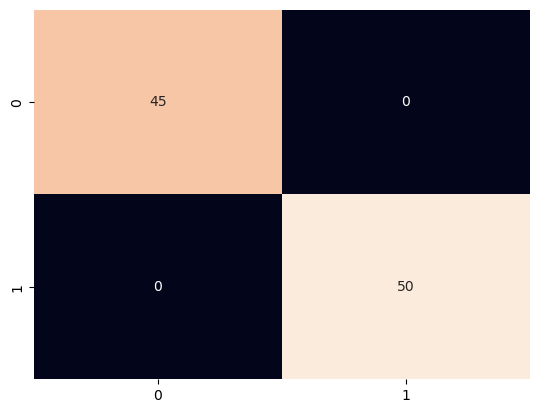

In [302]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);

In [306]:
xgb = XGBClassifier(random_state=51)

In [307]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=51, ...)

In [308]:
predictions = xgb.predict(X_test)

In [423]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %") 
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")
joblib.dump(xgb, "Audio_xgboost_model.joblib")

The accuracy is 100.00 %
The f1 score is 100.00 %
The recall is 100.00 %


['Audio_xgboost_model.joblib']

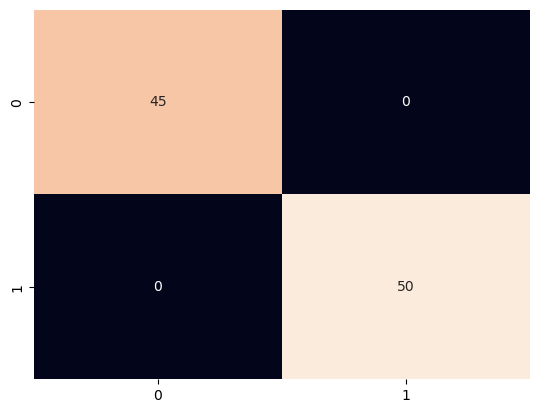

In [310]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);
# TN   FP
# FN*   TP - Recall

In [312]:
svm = SVC()

In [313]:
svm.fit(X_train, y_train)

SVC()

In [314]:
predictions = svm.predict(X_test)

In [422]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %") 
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")
joblib.dump(svm, "Audio_svm_model.joblib")

The accuracy is 100.00 %
The f1 score is 100.00 %
The recall is 100.00 %


['Audio_svm_model.joblib']

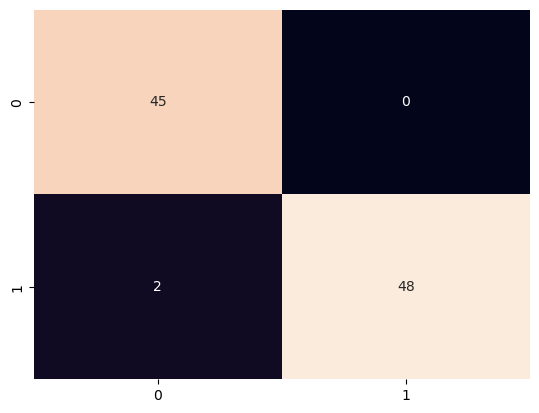

In [316]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);
# TN   FP
# FN*   TP - Recall

### Most important features
Here we check the top 10 most important features that contribute to the prediction of parkinsons
* spread1
* MDVP:Fo(Hz)
* PPE
* MDVP:Fhi(Hz)
* spread2
* MDVP:APQ
* MDVP:Flo(Hz)
* Shimmer:APQ5
* MDVP:PPQ
* MDVP:Shimmer


In [317]:
importance_df = pd.DataFrame({
    "Feature" : features,
    "Importance" : model.feature_importances_}).sort_values("Importance", ascending=False)

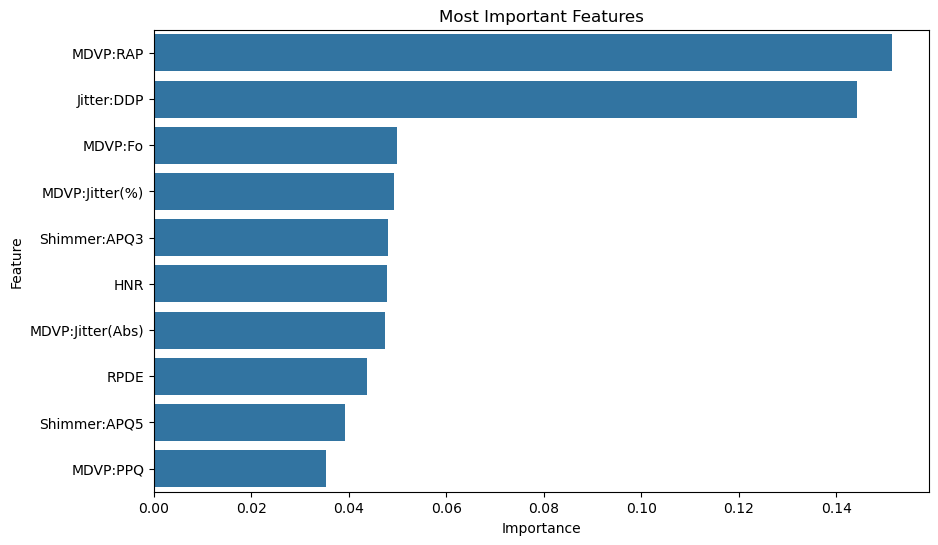

In [318]:
plt.figure(figsize=[10,6])
plt.title("Most Important Features")
sns.barplot(data=importance_df.head(10), y="Feature", x="Importance");

['FinnalAudiomodel_joblib']

#### Decision Tree Model

In [321]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MDVP:Fo,474.0,-1.037166,0.104588,-1.676252e+00,-1.063051,-1.039063,-1.009482,-0.648297
MDVP:Fhi,474.0,1.029404,0.103538,8.180781e-01,0.976579,1.033769,1.077592,1.620146
MDVP:Flo,474.0,0.018111,0.021486,1.058398e-04,0.005081,0.011189,0.022936,0.127891
MDVP:Jitter(%),474.0,0.223452,0.079437,6.858101e-02,0.170547,0.218415,0.276345,0.490935
MDVP:Jitter(Abs),474.0,0.172710,0.068243,5.198919e-02,0.133373,0.162602,0.211629,0.414686
MDVP:RAP,474.0,0.793543,0.109277,5.369163e-01,0.719813,0.780572,0.854493,1.137859
MDVP:PPQ,474.0,0.158824,0.044055,5.743362e-02,0.123892,0.159054,0.193057,0.251427
Jitter:DDP,474.0,1.587086,0.218554,1.073833e+00,1.439625,1.561144,1.708986,2.275718
MDVP:Shimmer,474.0,0.234709,0.060512,1.227818e-01,0.187901,0.231251,0.274492,0.446342
MDVP:Shimmer_dB,474.0,-6.441330,1.143975,-9.108660e+00,-7.260702,-6.359157,-5.614699,-3.503320


### Univariate Analysis

<Axes: ylabel='PPE'>

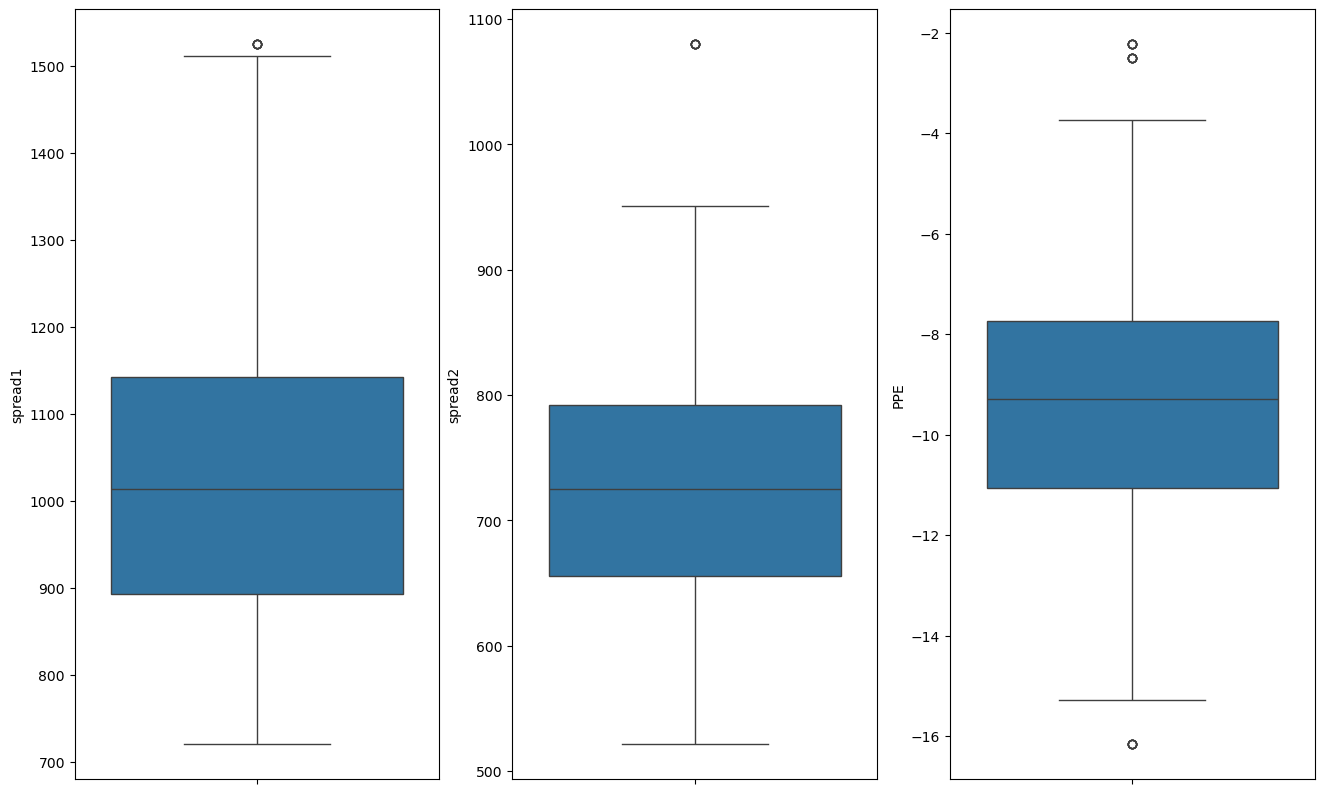

In [326]:
fig, ax = plt.subplots(1,3,figsize=(16,10)) 
sns.boxplot(y='spread1',data=df, ax=ax[0],orient='v') 
sns.boxplot(y='spread2',data=df, ax=ax[1],orient='v')
sns.boxplot(y='PPE',data=df,ax=ax[2],orient='v')

/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/826359729.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['MDVP:Flo'],ax=ax[0])
/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/826359729.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['MDVP:Fo'],ax=

<Axes: xlabel='MDVP:Fhi', ylabel='Density'>

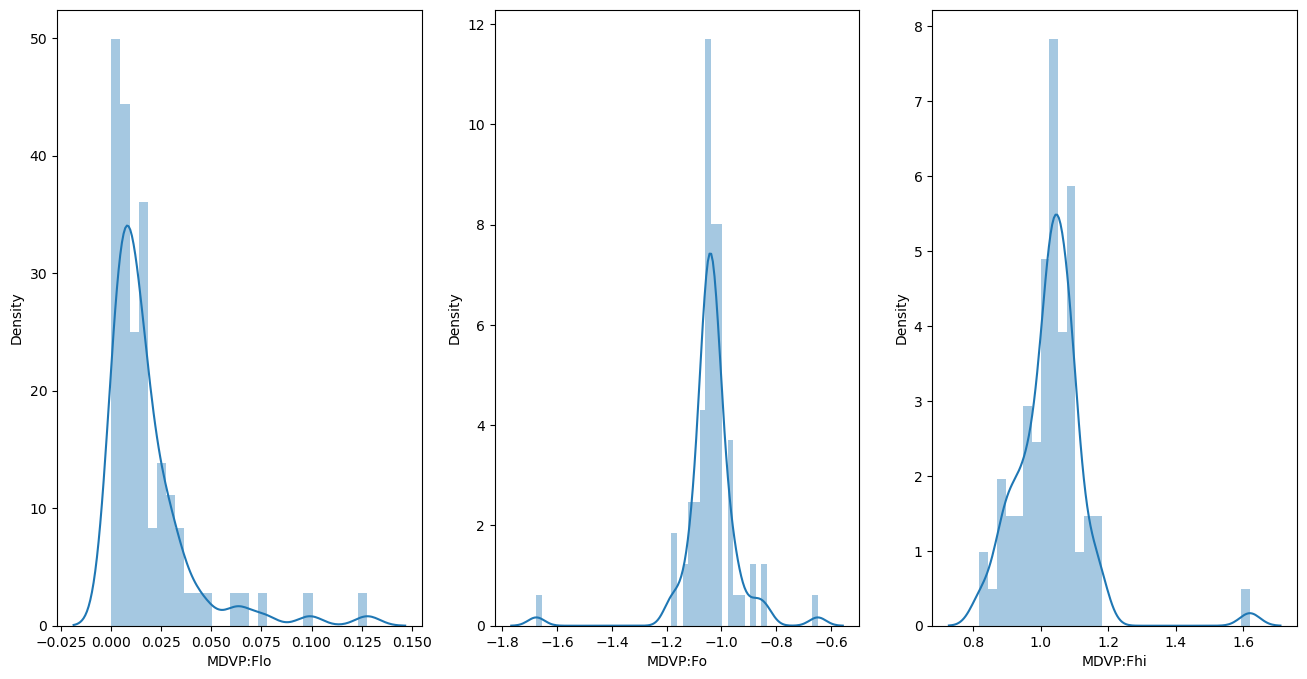

In [331]:
fig, ax = plt.subplots(1,3,figsize=(16,8)) 
sns.distplot(df['MDVP:Flo'],ax=ax[0]) 
sns.distplot(df['MDVP:Fo'],ax=ax[1]) 
sns.distplot(df['MDVP:Fhi'],ax=ax[2])

The measures of vocal fundamental frequency are shown above. There is a positive skewness for minimum vocal fundemental frequency with more high values between 75Hz and 125Hhz. The average vocal frequency is almost normally distributed with more values ranging 115Hz and 130Hz. The high vocal frequency does not have any skewness, but some range of values are at the right most tai

/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/3977229506.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['NHR'],ax=ax[0])
/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/3977229506.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['HNR'],ax=ax[1])


<Axes: xlabel='HNR', ylabel='Density'>

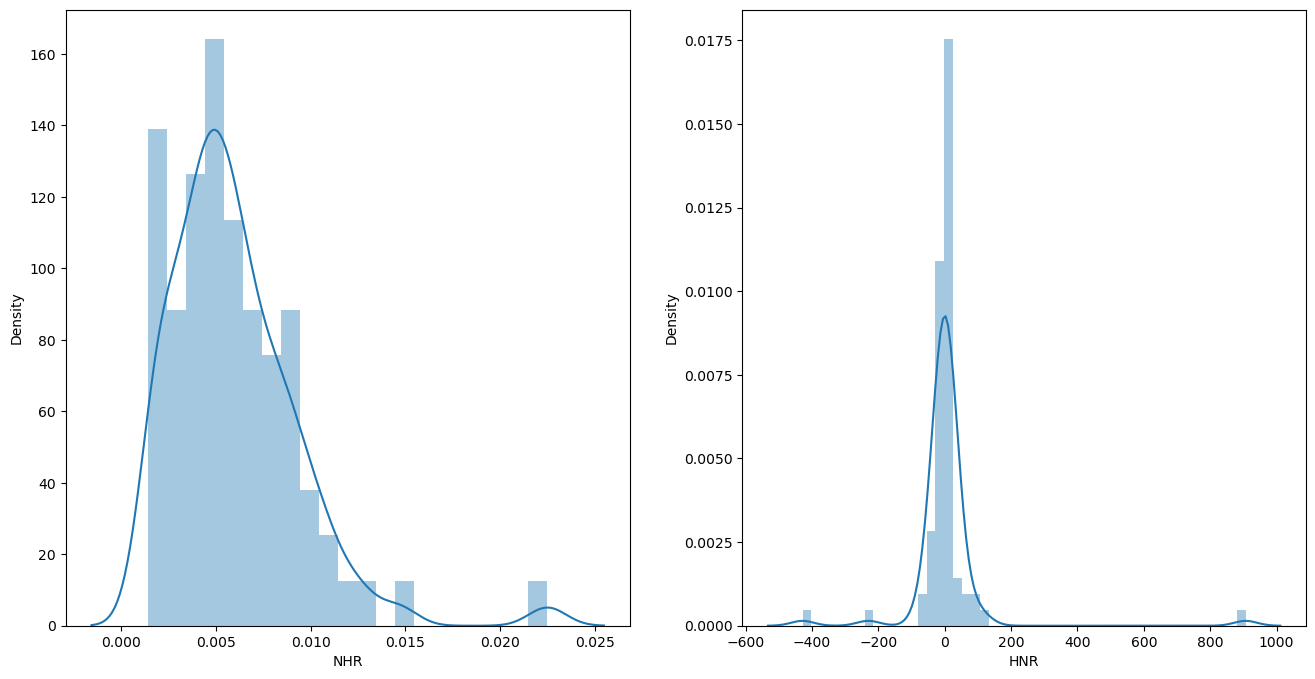

In [332]:
fig, ax = plt.subplots(1,2,figsize=(16,8)) 
sns.distplot(df['NHR'],ax=ax[0]) 
sns.distplot(df['HNR'],ax=ax[1])

The measure of tonal component of frequency is shown above. The value NHR is right skewed for there are so many observations in the area, but they seem to be with very minimal values. The maximum number of observations is between 0 and 0.04. The value HNR looks like normally distributed, but in a first look there seems to be a slight negative skewness

/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/2652494932.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['MDVP:Shimmer'],ax=ax[0,0])
/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/2652494932.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['MDVP:

<Axes: xlabel='Shimmer:DDA', ylabel='Density'>

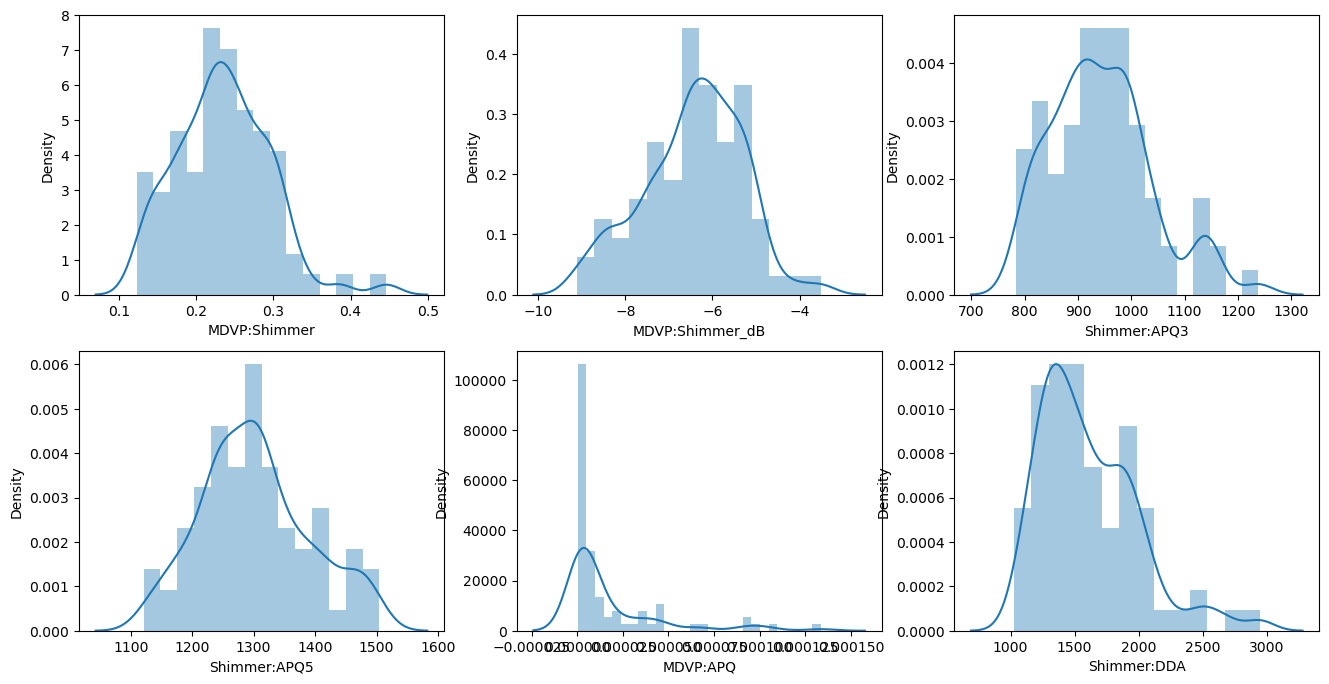

In [336]:
fig, ax = plt.subplots(2,3,figsize=(16,8)) 
sns.distplot(df['MDVP:Shimmer'],ax=ax[0,0]) 
sns.distplot(df['MDVP:Shimmer_dB'],ax=ax[0,1]) 
sns.distplot(df['Shimmer:APQ3'],ax=ax[0,2]) 
sns.distplot(df['Shimmer:APQ5'],ax=ax[1,0]) 
sns.distplot(df['MDVP:APQ'],ax=ax[1,1]) 
sns.distplot(df['Shimmer:DDA'],ax=ax[1,2])

For all of the above graphs, we can observe that the measure of variation in amplitude is positively skewed

### Bi -Variate Analysis

/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/1088879602.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df[df.Label == 0]['spread1'], color = 'r')
/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/1088879602.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp

<Axes: xlabel='spread1', ylabel='Density'>

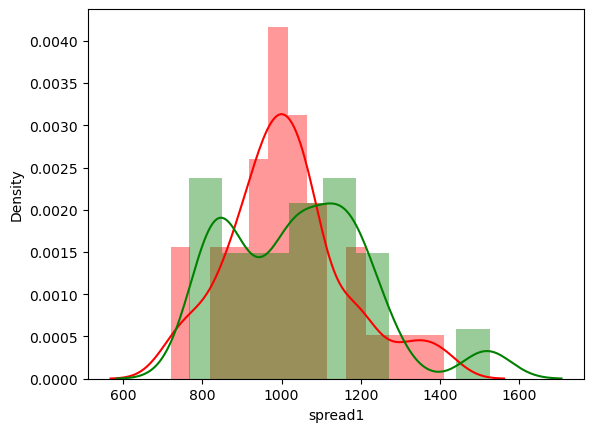

In [337]:
sns.distplot( df[df.Label == 0]['spread1'], color = 'r')
sns.distplot( df[df.Label == 1]['spread1'], color = 'g')

Spread1 is normally distributed between person who have PD and who is normal. People who have spread1 between - 8.5 and -7.5 are more and they are normal. People whose spread1 is between -6.5 and -5 are having PD


<Axes: xlabel='Label', ylabel='HNR'>

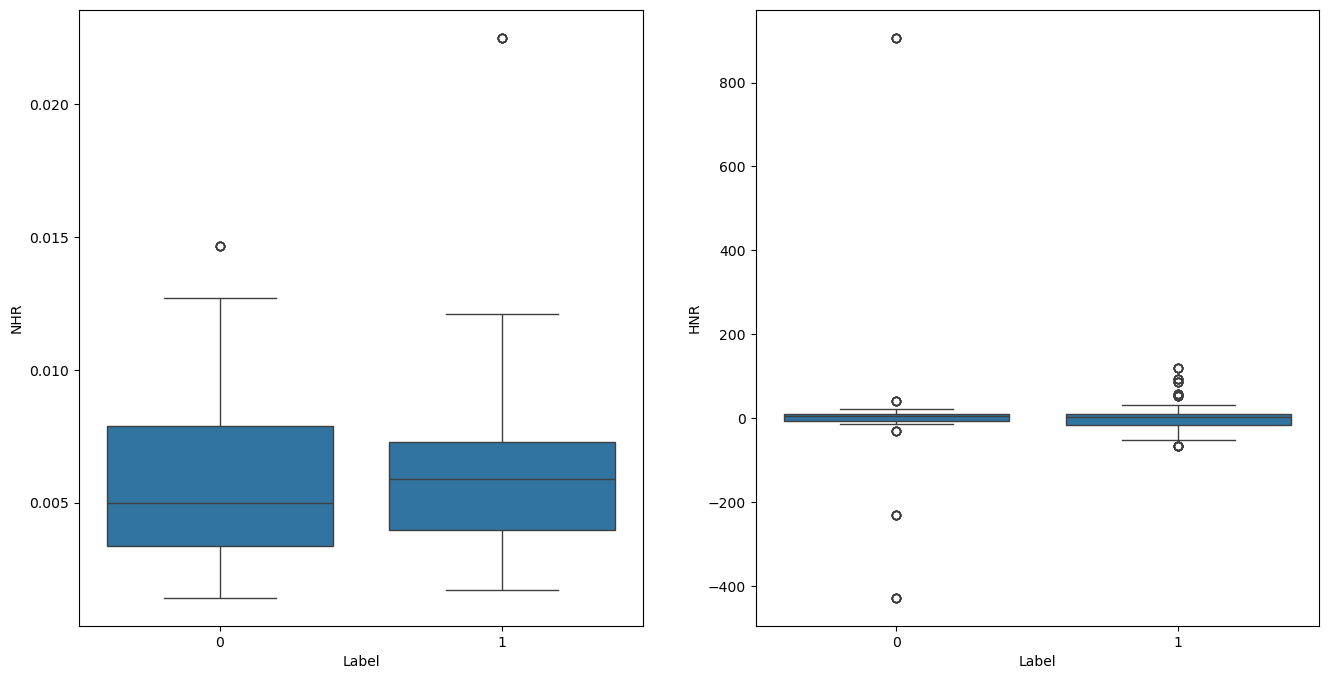

In [338]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(x='Label',y='NHR',data=df,ax=ax[0])
sns.boxplot(x='Label',y='HNR',data=df,ax=ax[1])

People who have PD(status equal to one) have higher levels of Noise to Harmonic ratio. Also, looking into the HNR ratio people who have PD have lower levels in the same.

/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/2564877965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label',y='MDVP:Flo',data=df,palette="Set1",ax=ax[0])
/var/folders/r9/q4xqtwfd4dbfq85pgd9bpswr0000gn/T/ipykernel_14811/2564877965.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label',y='MDVP:Fo',data=df,palette="Set1",ax=ax[1])


<Axes: xlabel='Label', ylabel='MDVP:Fo'>

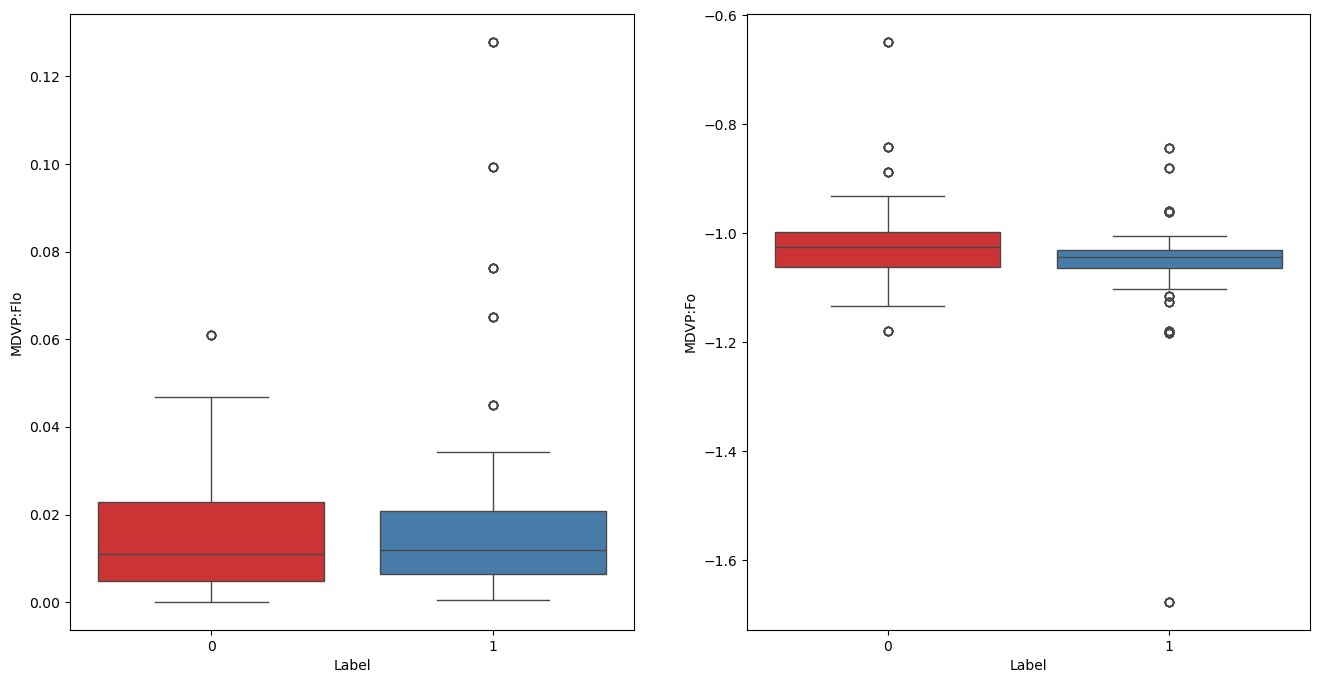

In [340]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(x='Label',y='MDVP:Flo',data=df,palette="Set1",ax=ax[0])
sns.boxplot(x='Label',y='MDVP:Fo',data=df,palette="Set1",ax=ax[1])


When we look the relationship between status and MDVP:Fo(Hz) we can see the median value is around 199 Hz for people who are normal. For people who are affected with Parkinsons the median value comes around 145 Hz

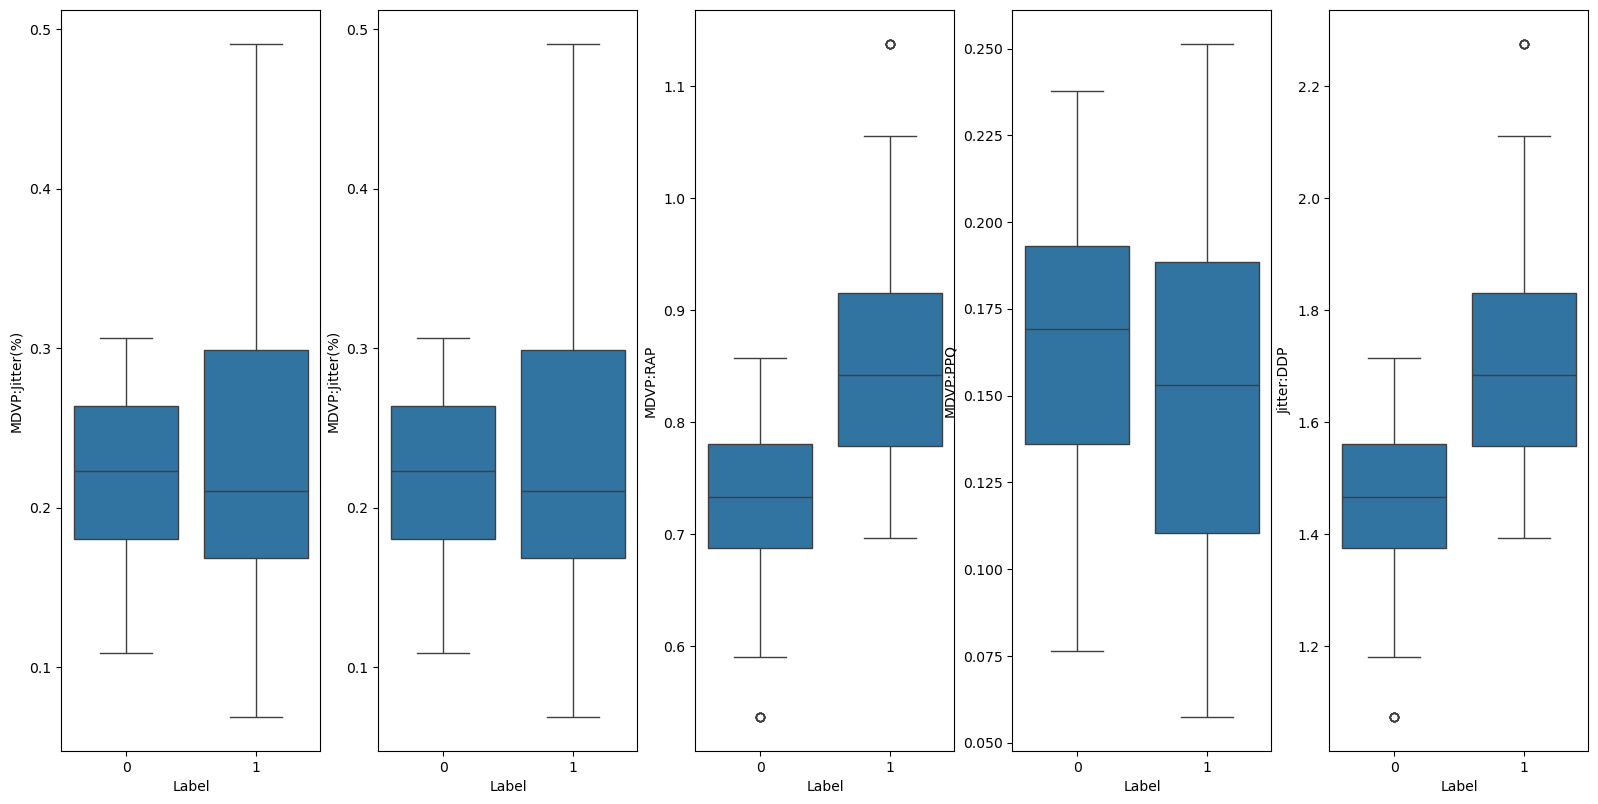

In [343]:
# For categorical predictors
cols = ["MDVP:Jitter(%)","MDVP:Jitter(%)","MDVP:RAP","MDVP:PPQ","Jitter:DDP"]
fig, axs = plt.subplots(ncols = 5,figsize=(16,8))
fig.tight_layout()
for i in range(0,len(cols)):
    sns.boxplot(x='Label',y=cols[i],data=df, ax = axs[i])

People who are suffering for PD tend to have higher jitter %. It seems if the values goes above 0.15 we can confirm the patient is having PD. The variation of fundamental frequency is in a low range for people who is normal.

### Correlation comparision with heat map

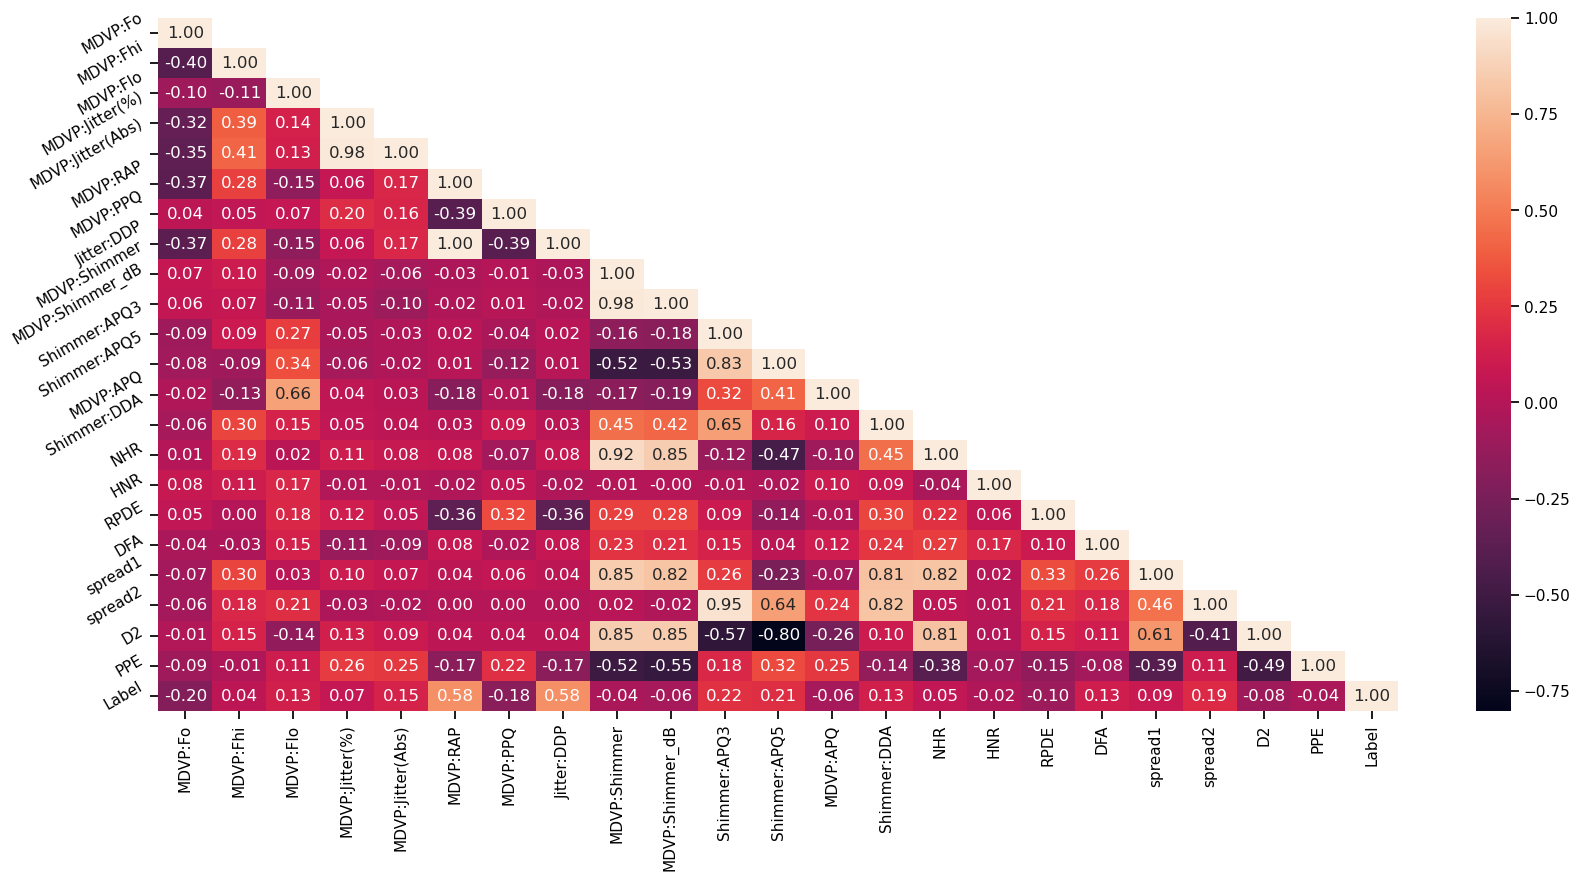

In [345]:
corr = df.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(20,9))
# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

1) MDVP:Jitter(%) has a very high correlation with MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP
2) MDVP:Shimmer has a very correlation with MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA this may be because they are related to each other. This may be because multi-dimensinal voice programs analysis is closely related with these variables
3) The target variable status has a weak positive corelation with spread1

## Applying Models


### Decision Tree

#### Decision trees can be used to predict both continuous and discrete values i.e. they work well for both regression and classification tasks.

In [347]:
X = df.drop("Label",axis=1)
Y = df["Label"]

In [348]:
# Splitting Data into 70% Training data and 30% Testing Data:
X_train, X_test, y_train,  y_test = train_test_split(X, Y,train_size=0.7, test_size=0.3, random_state=42)
print(len(X_train)),print(len(X_test))

331
143


(None, None)

In [351]:
dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=6,random_state=100,min_samples_leaf=5)

In [352]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5,
                       random_state=100)

In [357]:
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=100, splitter='best')

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5,
                       random_state=100)

In [358]:
dt_model.score(X_test , y_test)

0.916083916083916

In [359]:
y_pred = dt_model.predict(X_test)

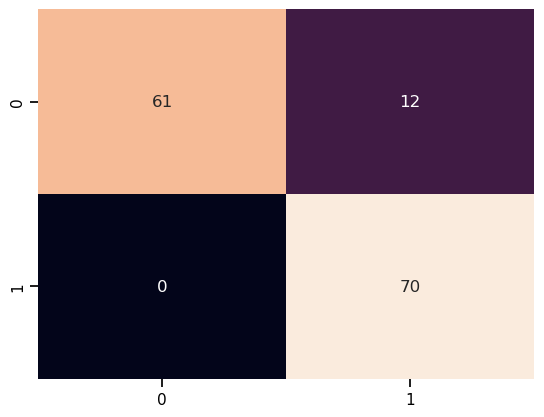

In [360]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cbar=False);

In [361]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))

Misclassified samples: 12


In [363]:
train_char_label = ['No', 'Yes']
pd_tree_regularized = open('pd_tree_regularized.dot','w')
dot_data = tree.export_graphviz(dt_model, out_file= pd_tree_regularized , feature_names = list(X_train), class_names = list(train_char_label))

pd_tree_regularized.close()

print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                       Imp
MDVP:Fo           0.000000
MDVP:Fhi          0.110721
MDVP:Flo          0.000000
MDVP:Jitter(%)    0.000000
MDVP:Jitter(Abs)  0.152493
MDVP:RAP          0.344369
MDVP:PPQ          0.145785
Jitter:DDP        0.083226
MDVP:Shimmer      0.000000
MDVP:Shimmer_dB   0.000000
Shimmer:APQ3      0.081898
Shimmer:APQ5      0.000000
MDVP:APQ          0.000000
Shimmer:DDA       0.000000
NHR               0.000000
HNR               0.000000
RPDE              0.081509
DFA               0.000000
spread1           0.000000
spread2           0.000000
D2                0.000000
PPE               0.000000


In [421]:
feature_names = df.columns[:-1].tolist()
target_names = [str(label) for label in df['Label'].unique().tolist()]

dot_data = export_graphviz(dt_model, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  

# Render the DOT file to a PNG image
graph = graphviz.Source(dot_data)
graph.render("Parkinsons_decision_tree", format="png")
Image("/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Parkinsons_decision_tree.png")
joblib.dump(dt_model, "Audio_decision_tree_model.joblib")

['Audio_decision_tree_model.joblib']

### KNN Model


In [405]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test,y_test)

0.972027972027972

In [420]:
y_pred = knn.predict(X_test)
joblib.dump(knn, "Audio_knn_model.joblib")

['Audio_knn_model.joblib']

In [407]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in KNN: {}'.format(count_misclassified))

Misclassified samples in KNN: 4


### Random forest


In [419]:
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, y_train)
y_pred = rfcl.predict(X_test)
rfcl.score(X_test , y_test)
joblib.dump(model_rf, "Audio_random_forest_model.joblib")

['Audio_random_forest_model.joblib']

In [380]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in Random Forest: {}'.format(count_misclassified))

Misclassified samples in Random Forest: 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


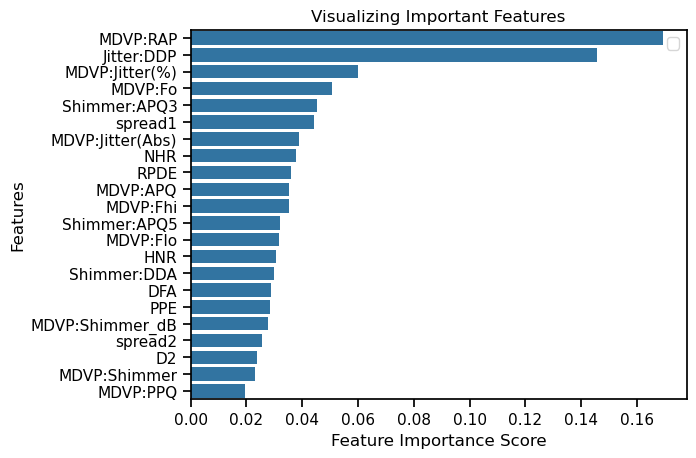

In [381]:
feature_imp = pd.Series(rfcl.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Bagging 


In [418]:
bgcl = BaggingClassifier(base_estimator=dt_model, n_estimators=50, max_samples=.7)
bgcl = bgcl.fit(X_train, y_train)
y_pred = bgcl.predict(X_test)
bgcl.score(X_test , y_test)
joblib.dump(bgcl, "Audio_bagging_model.joblib")

/Users/yashtembhurnikar/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


['Audio_bagging_model.joblib']

In [383]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in Bagging: {}'.format(count_misclassified))

Misclassified samples in Bagging: 0


### AdaBoosting

In [417]:
abcl = AdaBoostClassifier( n_estimators= 50)
abcl = abcl.fit(X_train,y_train)
y_pred = abcl.predict(X_test)
abcl.score(X_test , y_test)
joblib.dump(abcl, "Audio_adaboost_model.joblib")

['Audio_adaboost_model.joblib']

In [385]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in Ada Boosting: {}'.format(count_misclassified))

Misclassified samples in Ada Boosting: 0


### Gradient Boosting

In [416]:
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05)
gbcl = gbcl.fit(X_train,y_train)
y_pred = gbcl.predict(X_test)
gbcl.score(X_test , y_test)
joblib.dump(gbcl, "Audio_gradient_boosting_model.joblib")

['Audio_gradient_boosting_model.joblib']

In [387]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in Gradient Boosting: {}'.format(count_misclassified))

Misclassified samples in Gradient Boosting: 2


### Naive Bayes Model

Naive Bayes Accuracy: 78.32%
Naive Bayes F1 Score: 76.34%
Naive Bayes Recall: 71.43%


['Audio_naive_bayes_model.joblib']

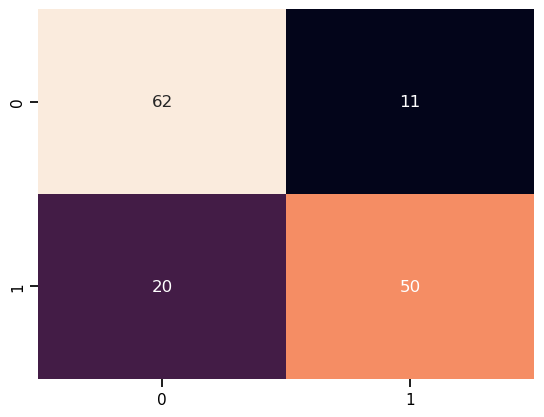

In [414]:
model_nb = gnb()
model_nb.fit(X_train, y_train)
predictions_nb = model_nb.predict(X_test)
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, predictions_nb) * 100:.2f}%")
print(f"Naive Bayes F1 Score: {f1_score(y_test, predictions_nb) * 100:.2f}%")
print(f"Naive Bayes Recall: {recall_score(y_test, predictions_nb) * 100:.2f}%")
sns.heatmap(confusion_matrix(y_test, predictions_nb), annot=True, cbar=False)
joblib.dump(model_nb, "Audio_naive_bayes_model.joblib")

In [435]:
def ensemble_model_predict():
    # Obtain predictions from each individual model
    pred_rf = rfcl.predict(X_test)
    pred_xgb = xgb.predict(X_test)
    pred_svm = svm.predict(X_test)
    pred_dt = dt_model.predict(X_test)
    pred_knn = knn.predict(X_test)
    pred_nb = model_nb.predict(X_test)
    pred_bagging = bgcl.predict(X_test)
    pred_adaboost = abcl.predict(X_test)
    pred_gradient_boosting = gbcl.predict(X_test)
    
    # Calculate the mode (most frequent value) among individual predictions
    ensemble_pred = np.array([
        mode(predictions) for predictions in zip(
            pred_rf, pred_xgb, pred_svm, pred_knn, pred_nb,
            pred_bagging, pred_adaboost, pred_gradient_boosting, pred_dt
        )
    ])
    
    print(f"Ensemble Accuracy: {accuracy_score(y_test, ensemble_pred) * 100:.2f}%")
    print(f"Ensemble F1 Score: {f1_score(y_test, ensemble_pred) * 100:.2f}%")
    print(f"Ensemble Recall: {recall_score(y_test, ensemble_pred) * 100:.2f}%")
    sns.heatmap(confusion_matrix(y_test, ensemble_pred), annot=True, cbar=False)
    return ensemble_pred


Ensemble Accuracy: 100.00%
Ensemble F1 Score: 100.00%
Ensemble Recall: 100.00%


['Audio_ensemble_model.joblib']

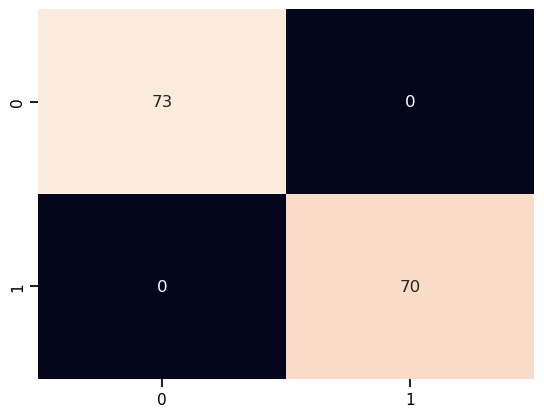

In [436]:
ensemble_predictions = ensemble_model_predict()  # Call the function to get the predictions
joblib.dump(ensemble_predictions, "Audio_ensemble_model.joblib")